# Customer Segmentation using RFM Analysis

## Step 0 — Imports


In [1]:
# Step 0: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
print('Libraries imported')

Libraries imported


## Step 1 — Load Dataset
Load the CSV file

In [12]:
# Step 1: Load dataset
df = pd.read_csv('data.csv', encoding='latin1')
print('Shape:', df.shape)
df.head()

Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Step 2 — Data Preprocessing
Steps:
- Convert `InvoiceDate` to datetime
- Remove rows with missing CustomerID
- Handle returns (negative Quantity)
- Create `TotalPrice` (Revenue) column



In [39]:
# Step 2: Data preprocessing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print('InvoiceDate converted. Range:', df['InvoiceDate'].min(), 'to', df['InvoiceDate'].max())

# Drop rows without CustomerID
missing_cust = df['CustomerID'].isna().sum()
print('Missing CustomerID rows:', missing_cust)
df = df.dropna(subset=['CustomerID']).copy()
df['CustomerID'] = df['CustomerID'].astype(int)

# Identify returns
returns = df[df['Quantity'] < 0].shape[0]
print('Negative-quantity rows (likely returns):', returns)

# Remove returns for RFM calculation
df = df[df['Quantity'] > 0].copy()

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Final check
df.info()
df.head()

InvoiceDate converted. Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Missing CustomerID rows: 0
Negative-quantity rows (likely returns): 0
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
 9   DayOfWeek    397924 non-null  object        
 10  Hour         397924 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(5)
memory usage: 34.9+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Wednesday,8


## Step 3 — RFM Calculation
Compute Recency, Frequency, Monetary per customer.
- **Recency:** days since last purchase (analysis date = max invoice date + 1 day)
- **Frequency:** number of unique invoices per customer
- **Monetary:** total revenue per customer

In [4]:
# Step 3: RFM Calculation
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print('Analysis date:', analysis_date.date())

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'InvoiceNo': pd.Series.nunique,
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm.describe().round(2)

Analysis date: 2011-12-10


,CustomerID,Recency,Frequency,Monetary
count,4339.00,4339.00,4339.00,4339.00
mean,15299.94,92.52,4.27,2053.79
std,1721.89,100.01,7.71,8988.25
min,12346.00,1.00,1.00,0.00
25%,13812.50,18.00,1.00,307.24
50%,15299.00,51.00,2.00,674.45
75%,16778.50,142.00,5.00,1661.64
max,18287.00,374.00,210.00,280206.02


## Step 4 — RFM Scoring
Score each R, F, M on quartiles (1–4). Higher R score = more recent (so Recency is inversed).

In [5]:
# Step 4: RFM Scoring using quartiles
# define helper to get quartile labels robustly
def score_quartiles(series, ascending=True):
    # ascending=True => higher values get higher score
    q1, q2, q3 = series.quantile([0.25,0.5,0.75]).values
    if ascending:
        bins = [-np.inf, q1, q2, q3, np.inf]
        labels = [1,2,3,4]
    else:
        # for Recency we want smaller recency -> higher score
        bins = [-np.inf, q1, q2, q3, np.inf]
        labels = [4,3,2,1]
    return pd.cut(series, bins=bins, labels=labels).astype(int)

rfm['R_score'] = score_quartiles(rfm['Recency'], ascending=False)
rfm['F_score'] = score_quartiles(rfm['Frequency'], ascending=True)
rfm['M_score'] = score_quartiles(rfm['Monetary'], ascending=True)

rfm['RFM_Score'] = rfm['R_score'].map(str) + rfm['F_score'].map(str) + rfm['M_score'].map(str)
rfm['RFM_Sum'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Sum
0,12346,326,1,77183.60,1,1,4,114,6
1,12347,2,7,4310.00,4,4,4,444,12
2,12348,75,4,1797.24,2,3,4,234,9
3,12349,19,1,1757.55,3,1,4,314,8
4,12350,310,1,334.40,1,1,2,112,4


## Step 5 — Clustering (K-Means)
Scale RFM and find optimal k using silhouette scores (k from 2 to 6). Then fit final KMeans.

In [40]:
# Step 5: Clustering
X = rfm[['Recency','Frequency','Monetary']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sil_scores = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

sil_scores

{2: np.float64(0.8958529121332962),
 3: np.float64(0.5943372749085692),
 4: np.float64(0.6161144819517276),
 5: np.float64(0.6157351702045593),
 6: np.float64(0.5982966460722171)}

In [41]:
# Choose k with highest silhouette
best_k = max(sil_scores, key=sil_scores.get)
print('Best k by sihouette:', best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)
# cluster centers (original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=['Recency','Frequency','Monetary'])
centers_df['Cluster'] = centers_df.index
centers_df

Best k by sihouette: 2


,Recency,Frequency,Monetary,Cluster
0,93.039648,3.896824,1548.317821,0
1,6.038462,66.500000,85904.351538,1


*****group customers into clusters using scaled RFM metrics; we used silhouette to select k.*****

sil_scores tells which k gives best separation.

centers_df provides the cluster centroids in original scales (helpful for naming segments).

## Step 6 — Segment Profiling
Summarize each cluster by Recency, Frequency, Monetary, and size. Also revenue share.

In [14]:
# Step 6: Segment profiling
profile = rfm.groupby('Cluster').agg({
    'Recency':'median',
    'Frequency':'median',
    'Monetary':['median','mean','sum'],
    'CustomerID':'count'
})
profile.columns = ['Recency_median','Frequency_median','Monetary_median','Monetary_mean','Monetary_sum','Customer_Count']
profile = profile.sort_values('Monetary_sum', ascending=False)
profile['Revenue_pct'] = 100 * profile['Monetary_sum'] / profile['Monetary_sum'].sum()
profile.round(2)

,Recency_median,Frequency_median,Monetary_median,Monetary_mean,Monetary_sum,Customer_Count,Revenue_pct
Cluster,,,,,,,
0,51.0,2.0,667.65,1548.32,6677894.76,4313,74.94
1,3.5,53.0,59796.87,85904.35,2233513.14,26,25.06


****clusters with high Monetary_median and Frequency_median are top customers — prioritize retention. Clusters with high Recency_median (large number of days) are inactive/at-risk — prioritize win-back.****

## Step 7 — Visualizations
A few plots to illustrate RFM distributions and clusters.

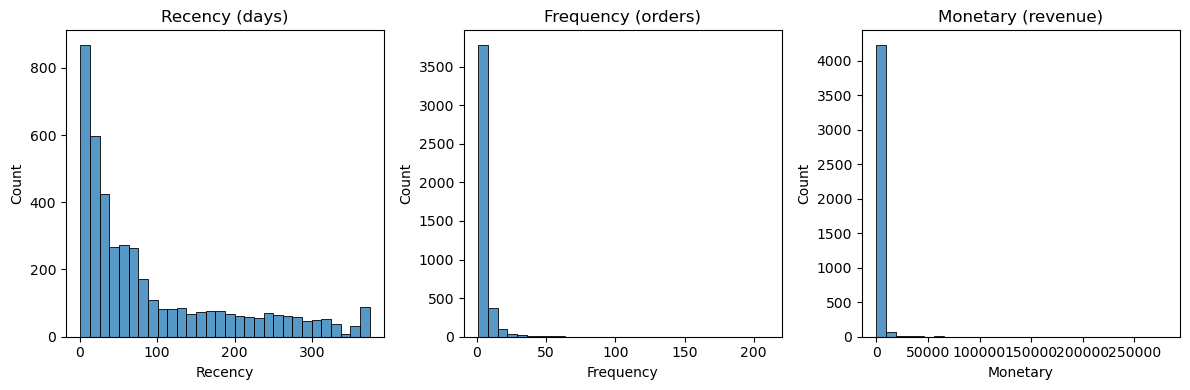

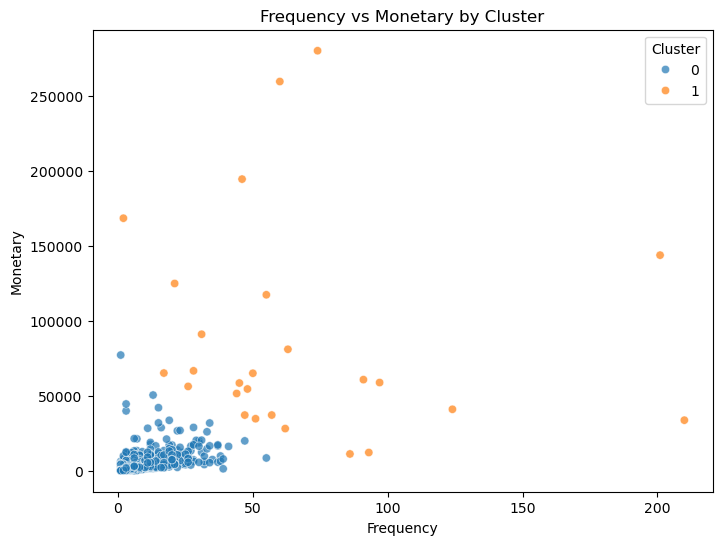

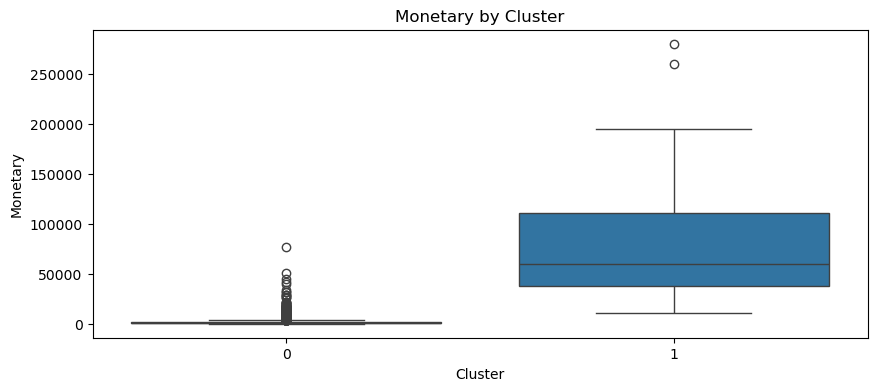

In [15]:
# Step 7: Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30)
plt.title('Recency (days)')

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title('Frequency (orders)')

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title('Monetary (revenue)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='tab10', alpha=0.7)
plt.title('Frequency vs Monetary by Cluster')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Monetary by Cluster')
plt.show()

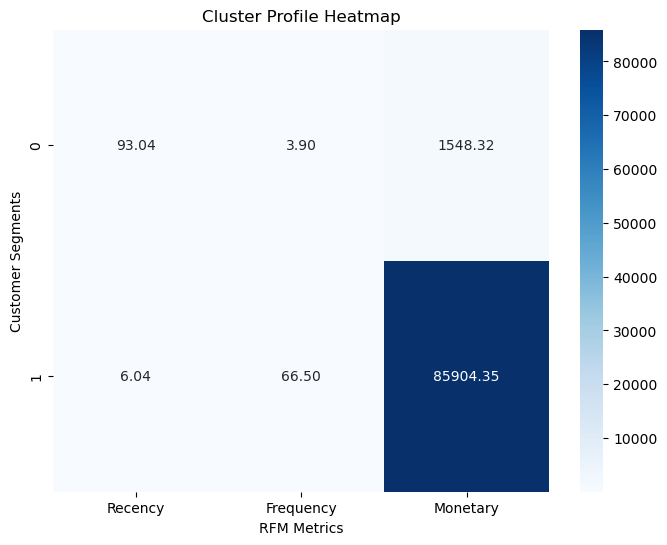

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your profile table is named "profile" or "cluster_profile"
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

plt.figure(figsize=(8,6))
sns.heatmap(cluster_profile, annot=True, cmap="Blues", fmt=".2f")
plt.title("Cluster Profile Heatmap")
plt.xlabel("RFM Metrics")
plt.ylabel("Customer Segments")
plt.show()


## Step 8 — Insights & Marketing Recommendations

In [10]:
# Step 8: Print cluster summaries AND recommendations (text)
print('Cluster profile summary:')
display(profile)

# Generate simple mapping recommendations based on medians
def recommend(cluster_row):
    r = cluster_row['Recency_median']
    f = cluster_row['Frequency_median']
    m = cluster_row['Monetary_median']
    if (r<=30) and (f>=3) and (m>100):
        return 'Champions: VIP offers, loyalty program, upsell premium products.'
    if (r<=90) and (f>=2):
        return 'Loyal: Cross-sell and retention offers, subscription nudges.'
    if (r>180) and (f>=1):
        return 'At-risk: Win-back campaigns with special offers.'
    return 'Low value/new: Welcome flows, educational content, small incentive for 2nd purchase.'

recs = {}
for idx, row in profile.iterrows():
    recs[idx] = recommend(row)

print('\nRecommendations per cluster:')
for k,v in recs.items():
    print('Cluster',k,':',v)

Cluster profile summary:


,Recency_median,Frequency_median,Monetary_median,Monetary_mean,Monetary_sum,Customer_Count,Revenue_pct
Cluster,,,,,,,
0,51.0,2.0,667.650,1548.317821,6677894.764,4313,74.936473
1,3.5,53.0,59796.865,85904.351538,2233513.140,26,25.063527



Recommendations per cluster:
Cluster 0 : Loyal: Cross-sell and retention offers, subscription nudges.
Cluster 1 : Champions: VIP offers, loyalty program, upsell premium products.


Champions / Best customers: VIP program, exclusive discounts, ask for referrals, early access. KPI: retention rate, repeat purchase frequency.

Loyal but low monetary: cross-sell, bundle with higher-margin items, personalized recommendations. KPI: AOV (average order value) lift.

At-risk / Dormant: win-back campaigns with personalized incentives, reactivation emails. KPI: reactivation conversion.

New / Low-value: welcome series, product education, low-friction offers for second purchase. KPI: second-purchase rate.

****Guideline 1 — Data overview****

Q: Dataset size, column descriptions, and period covered.

In [19]:
# Size
rows, cols = df.shape

# Columns
cols_list = df.columns.tolist()

# Period
min_date = df['InvoiceDate'].min().date()
max_date = df['InvoiceDate'].max().date()

rows, cols, cols_list, min_date, max_date


(397924,
 9,
 ['InvoiceNo',
  'StockCode',
  'Description',
  'Quantity',
  'InvoiceDate',
  'UnitPrice',
  'CustomerID',
  'Country',
  'TotalPrice'],
 datetime.date(2010, 12, 1),
 datetime.date(2011, 12, 9))

****Guideline 2 — Customer Analysis****

Q1: How many unique customers?

In [20]:
unique_customers = df['CustomerID'].nunique()
unique_customers

4339

Q2: Distribution of number of orders per customer & top 5 customers by order count.

In [22]:
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()
orders_per_customer.describe().round(2)
top5_customers = orders_per_customer.sort_values(ascending=False).head(5)
top5_customers

CustomerID
12748    210
14911    201
17841    124
13089     97
14606     93
Name: InvoiceNo, dtype: int64

****Guideline 3 — Product Analysis****

Q1: Top 10 most frequently purchased products.

In [23]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64

Q2: Average price of products.

In [24]:
avg_price = df['UnitPrice'].mean()
avg_price

np.float64(3.1161744805540756)

Q3: Product category revenue — dataset has only Description (no structured category). Use Description grouping.

In [25]:
top_revenue_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_revenue_products

Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalPrice, dtype: float64

****Guideline 4 — Time Analysis****

Q1: Day of week / time of day when most orders placed.

In [26]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour
orders_by_day = df['DayOfWeek'].value_counts()
orders_by_hour = df['Hour'].value_counts().sort_index()
orders_by_day, orders_by_hour

(DayOfWeek
 Thursday     80052
 Wednesday    68888
 Tuesday      66476
 Monday       64899
 Sunday       62775
 Friday       54834
 Name: count, dtype: int64,
 Hour
 6         1
 7       379
 8      8691
 9     21945
 10    37999
 11    49092
 12    72069
 13    64031
 14    54127
 15    45372
 16    24093
 17    13072
 18     2929
 19     3322
 20      802
 Name: count, dtype: int64)

Q2: Average order processing time.

***This dataset does not include processing/shipping timestamps (only invoice time). If the dataset included OrderPlaced and ShippedDate we could compute differences.***

Q3: Seasonal trends.

In [27]:
monthly_rev = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()
monthly_rev.plot(figsize=(12,4), title='Monthly Revenue')

<Axes: title={'center': 'Monthly Revenue'}, xlabel='InvoiceDate'>

****Guideline 5 — Geographical Analysis****

Q1: Top 5 countries by orders.

In [28]:
top_countries = df['Country'].value_counts().head(5)
top_countries

Country
United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: count, dtype: int64

Q2: Correlation between country and average order value.

In [30]:
country_avg_order = df.groupby('Country')['TotalPrice'].mean().sort_values(ascending=False)
country_avg_order.head(10)

Country
Netherlands    120.798282
Australia      116.895620
Japan          116.561900
Singapore       95.852658
Sweden          85.096075
Denmark         49.882474
Lithuania       47.458857
Lebanon         37.641778
EIRE            36.687745
Brazil          35.737500
Name: TotalPrice, dtype: float64

****Guideline 6 — Payment Analysis****

Q: What are the most common payment methods and their relation to order amount?

***Answer / Code: The provided dataset does not include payment method. Mention this limitation clearly.***

****Guideline 7 — Customer Behavior****

Q1: Average active lifetime (first to last purchase).

In [31]:
cust_activity = df.groupby('CustomerID').agg(first=('InvoiceDate','min'), last=('InvoiceDate','max'))
cust_activity['active_days'] = (cust_activity['last'] - cust_activity['first']).dt.days
cust_activity['active_days'].mean()

np.float64(130.4185296151187)

Q2: Are there customer segments based on purchase behavior?

****Answer: Yes — from RFM quartile labels and K-Means clusters. Show counts per RFM segment or cluster:****

In [32]:
rfm['Segment'] = rfm['RFM_Score']  # or map cluster labels
rfm['Segment'].value_counts().head()
rfm['Cluster'].value_counts().sort_index()

Cluster
0    4313
1      26
Name: count, dtype: int64

****Guideline 8 — Returns and Refunds****

Q1: Percentage of orders with returns/refunds.

In [34]:
total_transactions = df.shape[0]
# We previously removed returns from df for RFM; to compute returns percentage use original file (before removal)
orig = pd.read_csv('data.csv', encoding='latin1')
returns_count = (orig['Quantity'] < 0).sum()
returns_pct = 100 * returns_count / orig.shape[0]
returns_count, orig.shape[0], returns_pct

(np.int64(10624), 541909, np.float64(1.9604767590130445))

Q2: Correlation between product category and returns.

***Answer: There is no structured Category field; use Description keywords or manual mapping. Example approach:***

In [35]:
# Keyword-based example:
orig['is_toy'] = orig['Description'].str.contains('TOY|DOLL|...|', case=False, na=False)
orig.groupby('is_toy')['Quantity'].apply(lambda x: (x<0).sum())

is_toy
False     862
True     9762
Name: Quantity, dtype: int64

****Guideline 9 — Profitability Analysis****

Q1: Total profit.

***Answer: The dataset lacks cost or margin per product, so we cannot compute profit accurately. We can compute revenue but not profit.***

In [36]:
total_revenue = df['TotalPrice'].sum()
total_revenue

np.float64(8911407.904)

In [38]:
assumed_margin = 0.30
estimated_profit = total_revenue * assumed_margin

****Guideline 10 — Customer Satisfaction****

Q: Is there customer feedback/ratings?

***Answer: The dataset does not include ratings or textual feedback. If you had review text or rating fields you would run sentiment analysis; provide code if requested.***